Nama: Bening Maulina Fittamami;
email: beningmaulina@gmail.com 

---

Kelas Belajar Pengembangan Machine Learning (Proyek Time Series);
Digital Talent Scholarship Kominfo

---

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('D202.csv')
data_train

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


In [3]:
data_train.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [4]:
data_train.tail()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN
70367,Electric usage,10/24/2018,23:45,23:59,0.03,kWh,$0.01,NaN


In [5]:
data_train.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

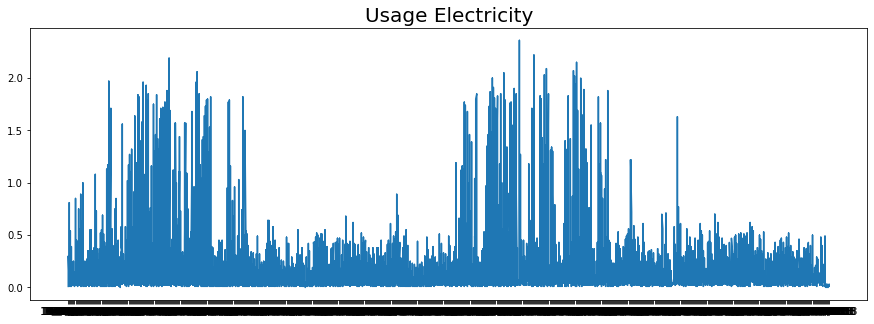

In [6]:
Date = data_train['DATE'].values
Usage  = data_train['USAGE'].values
     
     
plt.figure(figsize=(15,5))
plt.plot(Date, Usage)
plt.title('Usage Electricity',
           fontsize=20);

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
     series = tf.expand_dims(series, axis=-1)
     ds = tf.data.Dataset.from_tensor_slices(series)
     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
     ds = ds.shuffle(shuffle_buffer)
     ds = ds.map(lambda w: (w[:-1], w[-1:]))
     return ds.batch(batch_size).prefetch(1)

In [22]:
#Membagi Data Training dan Data Testing
from sklearn.model_selection import train_test_split
Usage_latih, Usage_test, Date_latih, Date_test = train_test_split(Usage, Date, test_size=0.2, random_state=123)

In [23]:
Usage_latih = windowed_dataset(Usage_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    ])

In [24]:
Date_latih = windowed_dataset(Date_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    ])

In [25]:
from tensorflow import keras
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
       if(logs.get('mae')<0.1):
        print("\nMAE telah mencapai <10%!")
        self.model.stop_training = True

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
history = model.fit(Usage_latih, epochs=50, callbacks=[MyCallback()])

Epoch 1/50
563/563 [==============================] - 64s 106ms/step - loss: 0.0233 - mae: 0.0999

MAE telah mencapai <10%!
